# Homework #1- Single LIF Neuron
Taylor Salo

[Instructions](http://faculty.fiu.edu/~fasoto/courses/COMPNEURO/HW1-LIF.pdf)

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import brian2 as br
import pylab as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("bright", 10))

## Q1 A Single LIF Neuron

In [2]:
# Start scope for brian2 simulation
br.start_scope()

# Define parameters of the LIF model
R = 100 * br.Mohm  # membrane resistance
tau = 10 * br.ms  # membrane time constant
thr = -50 * br.mV  # spike threshold
u_rest = -65 * br.mV  # resting potential
u_r = -70 * br.mV  # reset potential

# Define equation for the LIF model
eqs = '''
du/dt = ( -(u - u_rest) + R*I ) / tau : volt
I = input_current(t) : amp
'''

# Create stimulation timeseries
# I = 200pA, between 100 ms and 800 ms
tmp = np.zeros((1000,))
tmp[99:800] = 200

input_current = br.TimedArray(tmp*br.pamp, dt=1*br.ms)

LIF = br.NeuronGroup(N=1, model=eqs, method="linear",
                     threshold='u>thr', reset='u=u_r')
LIF.u = u_rest
rec = br.StateMonitor(LIF, 'u', record=True)
rec2 = br.SpikeMonitor(LIF, 'u', record=True)
br.run(1*br.second)

n_spikes = rec2.count[0]
n_secs = len(range(99, 800)) / 1000
spike_rate = n_spikes / n_secs
print spike_rate

61.3409415121


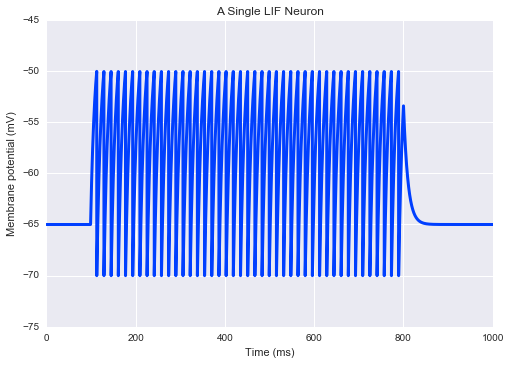

In [3]:
# Plot membrane potential against time for LIF neuron.
fig, ax = plt.subplots()
ax.plot(rec.t/br.ms, rec.u[0]*1000, label="State", lw=3.)
ax.set_ylim((-75, -45))
ax.set_title("A Single LIF Neuron")
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)')
plt.show(fig)

A constant input current of 200 pA causes a spike train of 61.3 spikes per second. After the first spike, a spike train occurs until the input current stops, at which point the LIF stops firing.

## Q2 Effect of Current Timing on LIF Spiking

In [4]:
# Set basic parameters.
R = 100 * br.Mohm  # membrane resistance
tau = 10 * br.ms  # membrane time constant
thr = -50 * br.mV  # spike threshold
u_rest = -65 * br.mV  # resting potential
u_r = -70 * br.mV  # reset potential

# Define equation for the LIF model
eqs = '''
du/dt = ( -(u - u_rest) + R*I ) / tau : volt
I = input_current(t) : amp
'''

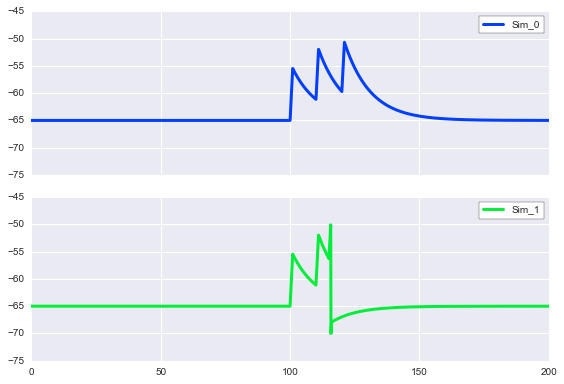

In [5]:
# Plot results of two simulations with different input timing parameters.
fig, axes = plt.subplots(2, sharex=True, sharey=True)
sim_times = np.array([[100, 110, 120],
                      [100, 110, 115]])

for i in range(sim_times.shape[0]):
    br.start_scope()
    tmp = np.zeros((1000,))
    tmp[sim_times[i, :]] = 1000

    input_current = br.TimedArray(tmp*br.pamp, dt=1*br.ms)
    
    LIF = br.NeuronGroup(N=1, model=eqs, method="linear",
                         threshold='u>thr', reset='u=u_r')
    LIF.u = u_rest
    rec = br.StateMonitor(LIF, 'u', record=True)
    br.run(1*br.second)
    
    axes[i].plot(rec.t/br.ms, rec.u[0]*1000,
                 color=sns.color_palette("bright", 10)[i],
                 label="Sim_{0}".format(i),
                 lw=3.)
    legend = axes[i].legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("black")

axes[0].set_ylim((-75, -45))
axes[0].set_xlim((0, 200))
fig.title = "Effect of Stimulus Timing on LIF Spiking"
fig.tight_layout()
plt.show(fig)

In the first simulation, the input currents occur rapidly enough to increase the membrane potential, but not enough to cause a spike. In the second simulation, a spike occurs as a result of the last input. This is because the last input occurs soon enough after the second input to raise the membrane potential above -50 mV, the firing threshold, before the leak can lower the membrane potential too low.

## Q3 Effect of Current on Number of Spikes

In [6]:
# Define parameters of the LIF model
R = 100 * br.Mohm  # membrane resistance
tau = 10 * br.ms  # membrane time constant
thr = -50 * br.mV  # spike threshold
u_rest = -65 * br.mV  # resting potential
u_r = -70 * br.mV  # reset potential

# Define equation for the LIF model
eqs = '''
du/dt = ( -(u - u_rest) + R*I ) / tau : volt
I = input_current(t) : amp
'''

n_spikes = []
current_range = np.arange(100, 501, 20)
for current in current_range:
    br.start_scope()
    tmp = np.ones((1000,))
    tmp *= current

    input_current = br.TimedArray(tmp*br.pamp, dt=1*br.ms)
    
    LIF = br.NeuronGroup(N=1, model=eqs, method="linear",
                         threshold='u>thr', reset='u=u_r')
    LIF.u = u_rest
    rec = br.SpikeMonitor(LIF, 'u', record=True)
    br.run(1*br.second)
    n_spikes.append(rec.count[0])

n_spikes = np.array(n_spikes)

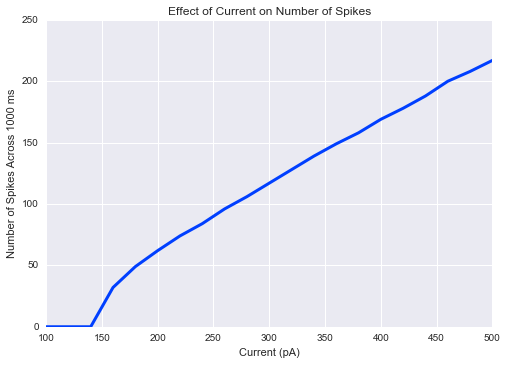

In [7]:
# Plot number of spikes against current value.
fig, ax = plt.subplots()
ax.plot(current_range, n_spikes, lw=3.)
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Number of Spikes Across 1000 ms')
ax.set_title("Effect of Current on Number of Spikes")
plt.show(fig)

Up to a point, a constant input current will not cause any firing in an LIF neuron. This explains the horizontal portion of the line plot where the spike rate is zero (100pA < *I* < 140pA). After reaching a current value where spikes will occur, the spike rate increases as the current increases. The rate at which the spike rate increases decreases as current increases.

## Q4 Effect of Noise on LIF Firing

In [8]:
# Define parameters of the LIF model
R = 100 * br.Mohm  # membrane resistance
tau = 10 * br.ms  # membrane time constant
thr = -50 * br.mV  # spike threshold
u_rest = -65 * br.mV  # resting potential
u_r = -70 * br.mV  # reset potential

# Add noise
sigma = 1 * br.mvolt
eqs= '''
du/dt = ( -(u - u_rest) + R*I ) / tau + sigma*xi*tau**-0.5 : volt
I = input_current(t) : amp
'''

n_spikes_wn = []
current_range = np.arange(100, 501, 20)
for current in current_range:
    br.start_scope()
    tmp = np.ones((1000,))
    tmp *= current

    input_current = br.TimedArray(tmp*br.pamp, dt=1*br.ms)
    
    LIF = br.NeuronGroup(N=1, model=eqs, method="euler",
                         threshold='u>thr', reset='u=u_r')
    LIF.u = u_rest
    rec = br.SpikeMonitor(LIF, 'u', record=True)
    br.run(1*br.second)
    n_spikes_wn.append(rec.count[0])

n_spikes_wn = np.array(n_spikes_wn)

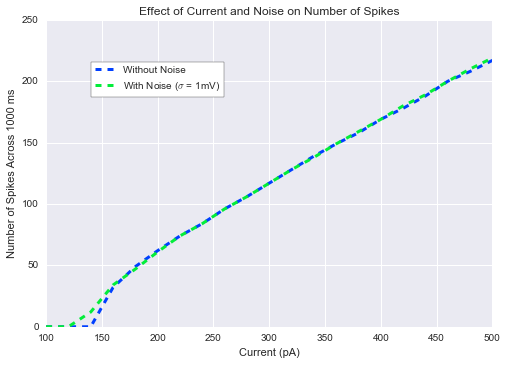

In [9]:
# Plot number of spikes against current value.
fig, ax = plt.subplots()
ax.plot(current_range, n_spikes, "--", lw=3.,
        label="Without Noise")
ax.plot(current_range, n_spikes_wn, "--", lw=3.,
        label=r"With Noise ($\sigma$ = 1mV)")
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Number of Spikes Across 1000 ms')
ax.set_title("Effect of Current and Noise on Number of Spikes")

legend = ax.legend(frameon=True, loc=(.1, .75))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_edgecolor("black")

plt.show(fig)

The simulations with noise perform similarly to the siulations without noise at higher values for *I*, but have increased numbers of spikes at lower levels of *I*. This is because noise increases the variability of the membrane potential within a simulation, which can cause "spurious" spikes within the neuron. This increases the spike rate when the neuron would not normally fire (i.e, at lower values of *I*), but doesn't significantly affect the spike rate when the neuron would fire (i.e., at higher values of *I*).